MASSACHUSETTS INSTITUTE OF TECHNOLOGY<br>
SYSTEM DESIGN & MANAGEMENT<br>
Author: R. Chadwick Holmes<br>
Date: June 5, 2021<br>
Last Update: December 12, 2021<br><br>

**Label: Final Workflow, Script 7**<br>

Script Purpose:<br>
Script for analyzing uncertainty in results based on learned parameters for a neural network.
<br><br>

## Set environment

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [3]:
#!apt update
#!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirement
!pip install descartes cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install tensorflow==2.5.0
!pip install tensorflow_probability==0.13.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (1,842 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../python3-numpy_

In [4]:
# libraries for plotting maps
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# libraries for tensorflow and tensorflow probability
import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tfd = tfp.distributions
tfpl = tfp.layers
tf.keras.backend.set_floatx('float64')
print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

# scikit helper functions
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics

# general libraries
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns

import statsmodels.api as sm
from scipy import stats
from pathlib import Path
import pickle as pkl

TF version: 2.5.0
TFP version: 0.13.0


### Set seed for randomized elements in script

In [6]:
seed = 43

# define extent for mapping
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
extent = [xmin,xmax,ymin,ymax]

### Mount Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/Colab Notebooks/Data'

Mounted at /content/drive


### Load data from saved pickle file

In [8]:
datafolder = Path(path) 

#with open(datafolder/ "wells_shared.pkl","rb") as handle: 
with open(datafolder/ "wellsp4_shared.pkl","rb") as handle: 
#with open(datafolder/ "wellsp8_shared.pkl","rb") as handle: 
    datadict = pkl.load(handle)
    
# unpack
fulldf = datadict['data']
coords = datadict['coords']
X_train = datadict['X_train'].reset_index(drop=True)
X_val   = datadict['X_val'].reset_index(drop=True)
X_test  = datadict['X_test'].reset_index(drop=True)
yr_train = datadict['yr_train'].reset_index(drop=True)
yr_val   = datadict['yr_val'].reset_index(drop=True)
yr_test  = datadict['yr_test'].reset_index(drop=True)
yc_train = datadict['yc_train'].reset_index(drop=True)
yc_val   = datadict['yc_val'].reset_index(drop=True)
yc_test  = datadict['yc_test'].reset_index(drop=True)
yc_oh_train = datadict['yc_oh_train']
yc_oh_val  = datadict['yc_oh_val']
yc_oh_test  = datadict['yc_oh_test']

In [9]:
myprojection = ccrs.PlateCarree()

def createBasemap(clean=False):
    expl_area = datafolder / 'Exploration_area.shp'
    expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

    rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
    #stamen_terrain = cimgt.Stamen('terrain-background')

    # generate plot of NM with river and stock image
    plt.figure(figsize=(20,12))
    ax = plt.axes(projection=myprojection)

    # Add the Stamen data at zoom level 9.
    #ax.stock_img()
    #ax.add_image(stamen_terrain, 9)
    
    grayval = 255 #200
    ax.background_patch.set_facecolor((grayval/255, grayval/255, grayval/255))
    
    ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    ax.add_feature(expl_area_feat, facecolor='None',
                   #edgecolor='r', linewidth=2, alpha = 0.5)
                   edgecolor='k', linewidth=3, alpha = .5)

    ax.set_extent(extent,crs=myprojection)
    ax.gridlines(crs = myprojection, draw_labels=True,
                 linewidth=0.5, color='k', alpha=0.25, linestyle='-')
    return ax

### Test that plotting works

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


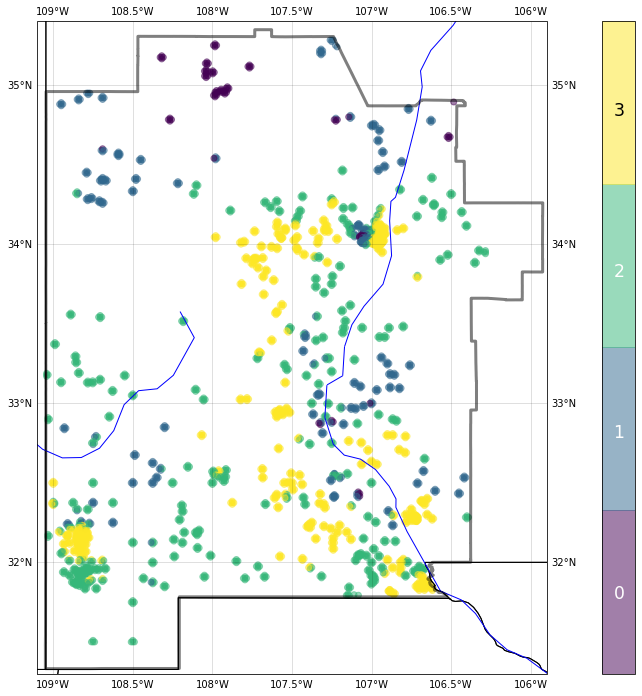

In [10]:
ax = createBasemap();
colmap=plt.cm.get_cmap('viridis', 4)
gdf = gpd.GeoDataFrame(fulldf.copy(deep=True), 
                       geometry=gpd.points_from_xy(coords.Longitude, coords.Latitude),
                       crs = {'init': 'epsg:4326'})
pc = ax.scatter(coords.Longitude,
                coords.Latitude,
                cmap=colmap,
                c=pd.cut(gdf['GeothermGrad'],bins=[-999,30,40,60,999],right=False,labels=False),
                alpha=0.5,
                transform=myprojection);
cbar = plt.colorbar(pc);
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
  if(j==3):
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
              fontsize='xx-large',fontweight='extra bold')
  else:
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                fontsize='xx-large',fontweight='extra bold')

### Plot Prep

In [11]:
## Set Plotting Parameters
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### TensorFlow Time
#### https://www.coursera.org/learn/probabilistic-deep-learning-with-tensorflow2 


### Data Prep

In [12]:
code2label = {0: 'Ultralow Gradient', 1: 'Low Gradient', 2: 'Medium Gradient', 3: 'High Gradient'}

In [13]:
X_test.columns

Index(['DEM', 'DEMGrad', 'Gravity', 'GravityGrad', 'Magnetic', 'MagneticGrad',
       'DosageRate', 'WTDepth', 'WTGrad', 'BasementDepth', 'CrustalThickness',
       'AirTemperature', 'Precipitation', 'StrainRate', 'QFaults',
       'StateFaults', 'Drainage', 'VolcanicDikes', 'SiGeothermometry',
       'Lithium', 'Boron', 'HeatFlow', 'Earthquakes', 'Vents', 'Springs',
       'GeothermGrad_2class'],
      dtype='object')

In [14]:
n_samples = fulldf.shape[0]
ntrain = int(0.70*n_samples)
nval   = int(0.15*n_samples)

# drop columns already determined to be colinear or are predicted variables
dropcols = ['AirTemperature','GeothermGrad','GeothermGrad_2class','GeothermGrad_4class']
print(dropcols)

fulldf['GradientCode'] = fulldf.GeothermGrad_4class.cat.codes
outcols = ['GradientCode']
incols =  set(fulldf.columns)-set(dropcols)-set(outcols)

Xtr = X_train[incols]
Xvl = X_val[incols]
Xts = X_test[incols]

# 4-class model
yc_val4   = yc_val['GeothermGrad_4class'].cat.codes
yc_test4  = yc_test['GeothermGrad_4class'].cat.codes
yc_train4 = yc_train['GeothermGrad_4class'].cat.codes

['AirTemperature', 'GeothermGrad', 'GeothermGrad_2class', 'GeothermGrad_4class']


In [15]:
## scale and transform data (use both to avoid bug in scikit)
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)
pl = Pipeline(steps=[('scale',sc),('powertransform',pt)])

colnames = list(Xtr.columns)
pl.fit(Xtr, yc_train)
Xtrsc = pd.DataFrame(pl.transform(Xtr), columns=colnames)
Xvlsc = pd.DataFrame(pl.transform(Xvl), columns=colnames)
Xtssc = pd.DataFrame(pl.transform(Xts), columns=colnames)

# encode classification variable
le = LabelEncoder()
le.fit(yc_train4)
yenc_trn = le.transform(yc_train4)
yenc_val = le.transform(yc_val4)
yenc_tst = le.transform(yc_test4)

Xtrvl = pd.concat([Xtr[colnames],Xvl[colnames]]).reset_index(drop=True)
Xtrnvalsc=pd.concat([Xtrsc[colnames],Xvlsc[colnames]]).reset_index(drop=True)
yenc_trnval=np.append(yenc_trn,yenc_val)
yc_oh_trnval=np.vstack((yc_oh_train,yc_oh_val))

In [16]:
print('train:')
counter = Counter(yc_train4)
for k,v in counter.items():
	per = v / len(yc_train4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
 
print('\nvalidate:')
counter = Counter(yc_val4)
for k,v in counter.items():
	per = v / len(yc_val4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

print('\ntest:')
counter = Counter(yc_test4)
for k,v in counter.items():
	per = v / len(yc_test4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

#print(list(Xtr))

train:
Class=2, n=801 (38.491%)
Class=3, n=860 (41.326%)
Class=1, n=349 (16.771%)
Class=0, n=71 (3.412%)

validate:
Class=2, n=171 (38.341%)
Class=3, n=185 (41.480%)
Class=1, n=75 (16.816%)
Class=0, n=15 (3.363%)

test:
Class=3, n=184 (41.256%)
Class=2, n=172 (38.565%)
Class=1, n=75 (16.816%)
Class=0, n=15 (3.363%)


## Build Bayesian Neural Network

In [17]:
# WDS4
learning_rate = 0.01
weight_reg = 2e-4
batch_size= 45
drop_rate = 0.1
n_epochs = 200

In [18]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(
            lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n,dtype=tf.float64), scale_diag=tf.ones(n,dtype=tf.float64))
        )
    ])
    return prior_model
    
# Define variational posterior weight distribution -- multivariate Gaussian
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n),dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

In [ ]:
# Probabilistic model
pmodel = tfk.Sequential([
      tfk.layers.Dense(len(incols), 
                       activation="relu", 
                       input_shape=(len(incols),), 
                       kernel_initializer='he_normal',
                       name="HiddenLayer1"), # Hidden layer 1
      tfk.layers.Dropout(0.0, name="Dropout1"),
      tfpl.DenseVariational(units=len(incols), 
                            make_prior_fn=prior, 
                            make_posterior_fn=posterior, # Probabilistic hidden layer
                            kl_weight=1/Xtrsc.shape[0], 
                            kl_use_exact=True, 
                            name="HiddenLayer2"),
      tfk.layers.Dropout(0.0, name="Dropout2"),
      tfk.layers.Dense(len(code2label), 
                       activation='softmax', 
                       name="OutputLayer") # Output layer
    ], name="BNN_Model")

# Compile model
pmodel.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=tfk.metrics.AUC(curve='ROC', multi_label=False))

# Run training session.
results = pmodel.fit(x=Xtrsc,
                    y=yc_oh_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(Xvlsc,yc_oh_val),
                    verbose=True)

# Describe model.
pmodel.summary()

Epoch 1/200
47/47 [==============================] - 2s 26ms/step - loss: 4.9420 - auc_2: 0.5071 - val_loss: 4.3530 - val_auc_2: 0.5360
Epoch 2/200
47/47 [==============================] - 1s 16ms/step - loss: 4.3824 - auc_2: 0.5471 - val_loss: 4.6938 - val_auc_2: 0.5208
Epoch 3/200
47/47 [==============================] - 1s 16ms/step - loss: 4.1159 - auc_2: 0.5459 - val_loss: 3.7171 - val_auc_2: 0.5589
Epoch 4/200
47/47 [==============================] - 1s 15ms/step - loss: 3.4397 - auc_2: 0.6096 - val_loss: 3.4725 - val_auc_2: 0.5947
Epoch 5/200
47/47 [==============================] - 1s 16ms/step - loss: 3.1072 - auc_2: 0.5665 - val_loss: 3.5269 - val_auc_2: 0.6151
Epoch 6/200
47/47 [==============================] - 1s 16ms/step - loss: 2.7358 - auc_2: 0.6160 - val_loss: 2.2718 - val_auc_2: 0.5917
Epoch 7/200
47/47 [==============================] - 1s 16ms/step - loss: 2.2539 - auc_2: 0.6244 - val_loss: 1.9980 - val_auc_2: 0.6517
Epoch 8/200
47/47 [=============================

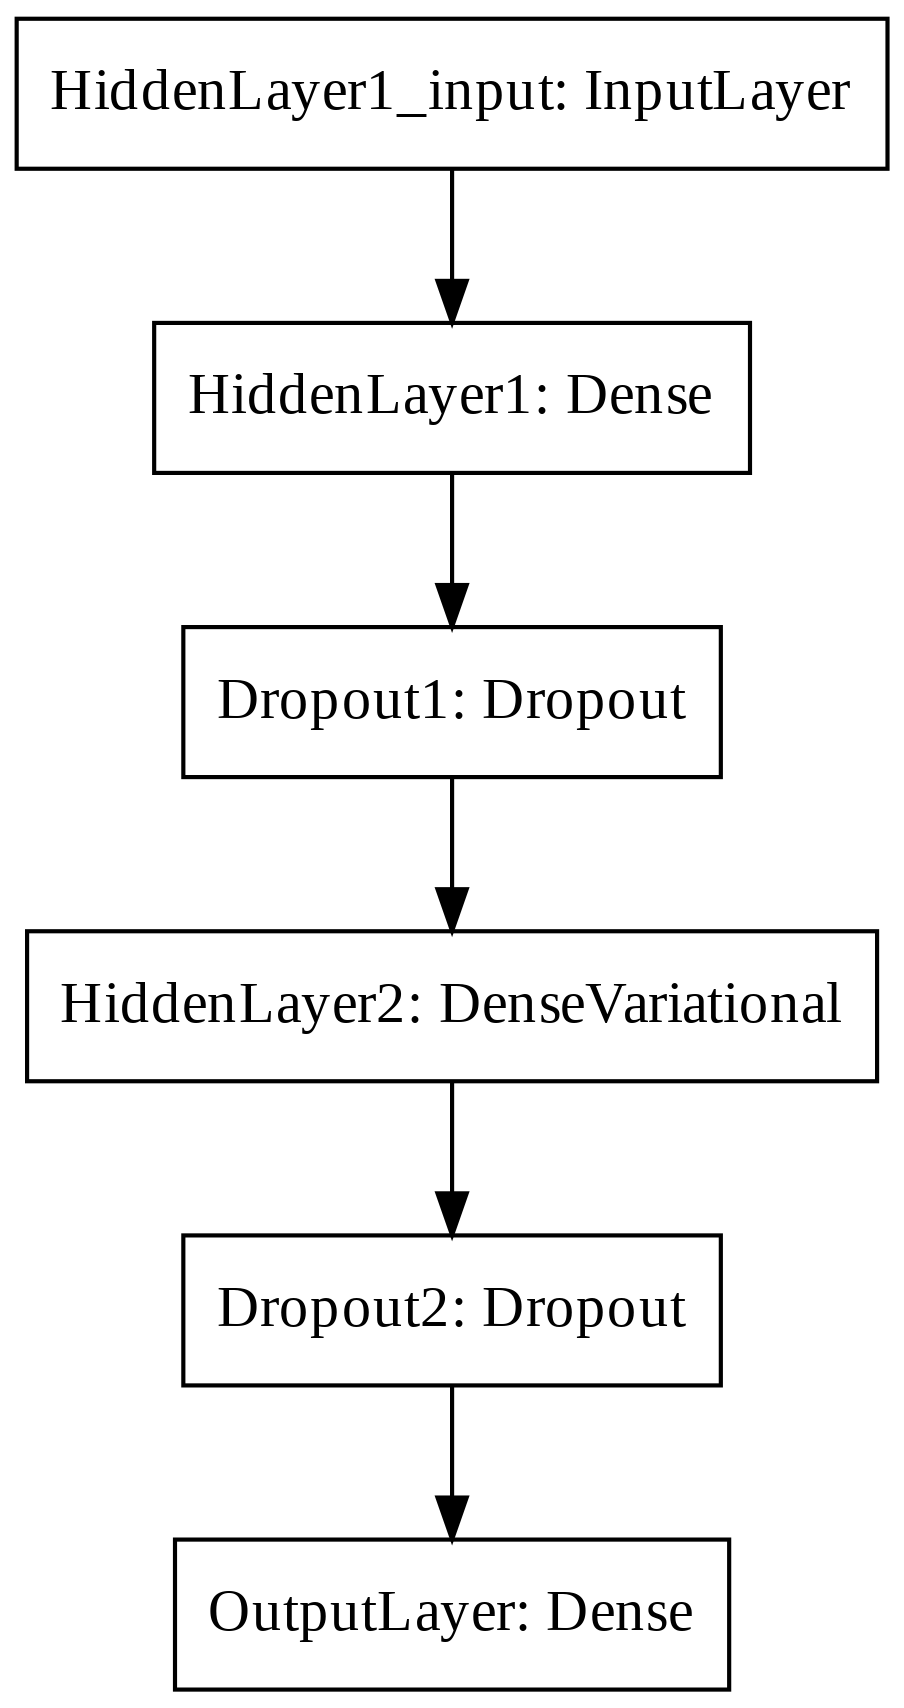

In [ ]:
tf.keras.utils.plot_model(pmodel,to_file=datafolder/'Figure-TF_BNN_plot.png',show_shapes=False,dpi=300,show_layer_names=True)

In [ ]:
# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([[0]])
pmodel_prior = pmodel.layers[2]._prior(dummy_input)
pmodel_posterior = pmodel.layers[2]._posterior(dummy_input)
print('prior mean:           ', pmodel_prior.mean().numpy())
print('prior variance:       ', pmodel_prior.variance().numpy())
print('posterior mean:       ', pmodel_posterior.mean().numpy())
print('posterior covariance: ', pmodel_posterior.covariance().numpy()[0])
print('                      ', pmodel_posterior.covariance().numpy()[1])

prior mean:            [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 

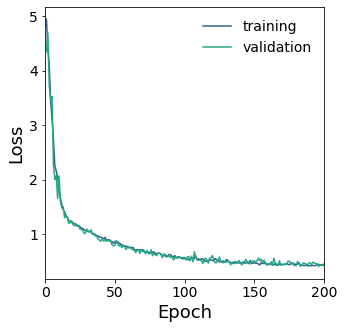

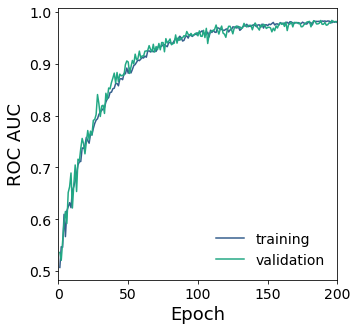

In [ ]:
# Plot the training session.
fig = plt.figure(figsize=(5,5))
fig.tight_layout()
plt.xlim(0, np.round(len(results.epoch)+4,-1))
#plt.ylim(0.0, 0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(list(map(lambda x: x + 1, results.epoch)), results.history['loss'],     label="training",   color=plt.cm.viridis(0.3))
plt.plot(list(map(lambda x: x + 1, results.epoch)), results.history["val_loss"], label="validation", color=plt.cm.viridis(0.6))
plt.legend(frameon=False, loc=0)
plt.savefig(datafolder / 'Fig-BNN-trainingloss.png',transparent=False,orientation='landscape',bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(5,5))
fig.tight_layout()
plt.xlim(0, np.round(len(results.epoch)+4,-1))
#plt.ylim(0.0, 0.5)
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.plot(list(map(lambda x: x + 1, results.epoch)), results.history["auc_2"],     label="training",   color=plt.cm.viridis(0.3))
plt.plot(list(map(lambda x: x + 1, results.epoch)), results.history["val_auc_2"], label="validation", color=plt.cm.viridis(0.6))
plt.legend(frameon=False, loc=0)
plt.savefig(datafolder / 'Fig-BNN-trainingauc.png',transparent=False,orientation='landscape',bbox_inches='tight')
plt.show()

In [ ]:
# evaluate the model
metric = tf.keras.metrics.CategoricalAccuracy()
metric.update_state(yc_oh_train,pmodel.predict(Xtrsc))
print('Train: accuracy, loss, auc:',metric.result().numpy(), pmodel.evaluate(Xtrsc, yc_oh_train, verbose=True))

metric.update_state(yc_oh_val,pmodel.predict(Xvlsc))
print('Validate: accuracy, loss, auc:',metric.result().numpy(), pmodel.evaluate(Xvlsc, yc_oh_val, verbose=True))

metric.update_state(yc_oh_test,pmodel.predict(Xtssc))
print('Test: accuracy, loss, auc:',metric.result().numpy(), pmodel.evaluate(Xtssc, yc_oh_test, verbose=True))

66/66 [==============================] - 0s 4ms/step - loss: 0.4189 - auc_2: 0.9828
Train: accuracy, loss, auc: 0.8803459875060067 [0.4189031113937714, 0.9827695534135187]
14/14 [==============================] - 0s 5ms/step - loss: 0.4108 - auc_2: 0.9834
Validate: accuracy, loss, auc: 0.8789077958053028 [0.41081171827650914, 0.9834184613940891]
14/14 [==============================] - 0s 5ms/step - loss: 0.4886 - auc_2: 0.9732
Test: accuracy, loss, auc: 0.8735284224688866 [0.48860901087039244, 0.97315533525039]


confusion matrix:
[[ 11   4   0   0]
 [  1  55  17   2]
 [  0  12 145  15]
 [  0   1  12 171]]

              precision    recall  f1-score   support

       No-GT       0.92      0.73      0.81        15
      Low-GT       0.76      0.73      0.75        75
      Med-GT       0.83      0.84      0.84       172
     High-GT       0.91      0.93      0.92       184

    accuracy                           0.86       446
   macro avg       0.86      0.81      0.83       446
weighted avg       0.86      0.86      0.86       446



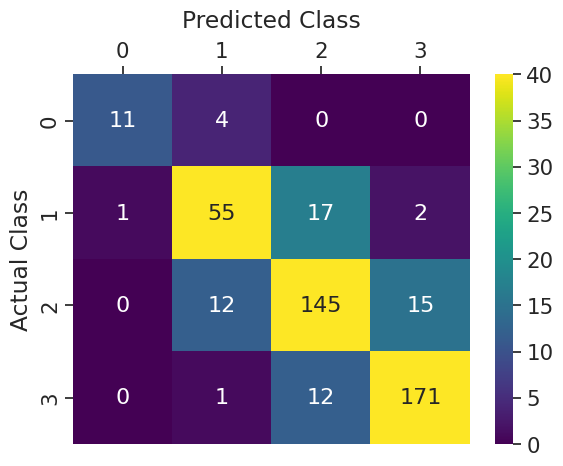

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

pred = np.argmax(pmodel.predict(Xtssc),axis=1)

# print confusion matrix
confusion = confusion_matrix(yenc_tst, pred)
print('confusion matrix:\n{}\n'.format(confusion))
print(classification_report(yenc_tst, pred, target_names=['No-GT','Low-GT','Med-GT','High-GT']))

with mpl.style.context('default'):
  df_cm = pd.DataFrame(confusion, range(4), range(4))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, cmap='viridis',vmax=40,annot=True, 
              fmt='g', annot_kws={"size": 16}) # font size
  plt.xlabel('Predicted Class',labelpad=10)
  ax = plt.gca()
  ax.xaxis.set_label_position('top') 
  plt.ylabel('Actual Class',labelpad=5)
  ax.xaxis.tick_top()
  ax.yaxis.tick_left()
  plt.savefig(datafolder / 'BayesianNeuralNetwork_WDS4_ConfusionMatrix.png', bbox_inches='tight')
  plt.show()

14/14 [==============================] - 0s 5ms/step - loss: 0.4912 - auc_2: 0.9738


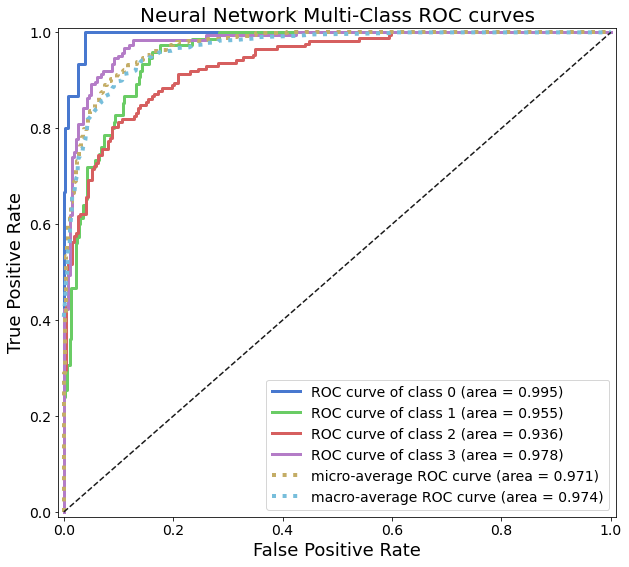

In [ ]:
## from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#area-under-roc-for-the-multiclass-problem
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from itertools import cycle
import matplotlib as mpl

# calculate previous model test results
pred_probs_test = pmodel.predict(Xtssc)
preds_test = np.argmax(pred_probs_test,axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes=[0,1,2,3]
n_classes = len(classes)
yt_bin = yc_oh_test
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yt_bin[:,i], pred_probs_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yt_bin.ravel(), pred_probs_test.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc['macro'] = pmodel.evaluate(Xtssc, yc_oh_test)[1]
#roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 3
with mpl.style.context("seaborn-muted"):
  plt.figure(figsize=(10,9))

  colors = cycle(['#4A67BF','#8C8C8C','#73A96C','#AD5153'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], lw=lw,   #color=color,lw=lw,alpha=.5,
              label='ROC curve of class {0} (area = {1:0.3f})'
              ''.format(i, roc_auc[i]))
      
  plt.plot(fpr["micro"], tpr["micro"],
           label='micro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["micro"]),
           linestyle=':', lw=(lw+1))  #color='#C98AC1',alpha=.5

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["macro"]),
           linestyle=':', lw=(lw+1))  #color='#82B3CC', lw=lw,alpha=.5

  plt.plot([0, 1], [0, 1], 'k--') #, lw=lw, alpha=0.5
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Neural Network Multi-Class ROC curves')
  plt.legend(loc="lower right")
  plt.savefig(datafolder / 'BayesianNeuralNetwork_WDS4_ROCplot.png', bbox_inches='tight')
  plt.show()

In [ ]:
# Define function to analyse model predictions versus true labels

# data as image
def make_img(data_index, x):
  fig,ax=plt.subplots(figsize=(10,1))
  oneim = [x.iloc[data_index].to_numpy() for _ in range(x.shape[1])]
  ax.imshow(oneim, cmap='Greys', vmin=-1, vmax=1)
  ax.axis('off')
  plt.show()

def examine_model_predictions(loc_index):
  x = Xtrsc
  y = yc_train4
  n = 100
  nc = len(code2label)
  alpha = 5

  make_bar_plot=False

  # Identify location  
  # Show data
  #print('------------------------------')
  #print('feature data:')
  #make_img(loc_index,x)

  # Print the "true" label
  print('------------------------------')
  print('Well index: ',loc_index)
  print('True label: ', code2label[y[loc_index]])
  print('')

  # Print the probabilities the model assigns
  print('------------------------------')
  print('Model estimated probabilities:')

  pred_probs = np.empty(shape=(n, nc))
  for i in range(n):
    pred_probs[i] = pmodel.predict(x.iloc[loc_index,:].to_numpy()[np.newaxis, ...])
  pct_low  = np.array([np.percentile(pred_probs[:, i], alpha/2) for i in range(nc)])
  pct_high = np.array([np.percentile(pred_probs[:, i], 100-(alpha/2)) for i in range(nc)])  

  entropy = stats.entropy(np.mean(pred_probs,axis=0),base=nc,axis=-1)
  print('Entropy: ',entropy)

  # Seaborn boxplot
  #fig, ax = plt.subplots(figsize=(6, 3))
  #sns.boxplot(data=pd.DataFrame(pred_probs,columns=code2label.values()))
  sns.displot(pd.DataFrame(pred_probs,columns=code2label.values()),
              fill=True, kind='kde')#,common_norm=False)
  #'kind='kde')
  ylim = plt.ylim();
  plt.text(x=0.25, y=ylim[0]+(np.diff(ylim)*0.8),fontsize=16,
           s='Average Entropy: {:0.2f}'.format(entropy))
  
  if(make_bar_plot == True):
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(nc), pct_high, color='red')
    bar[y[loc_index]].set_color('green')
    bar = ax.bar(np.arange(nc), pct_low-0.02, color='white', 
                linewidth=1, edgecolor='white')
    ax.set_xticks(ticks=[int(k) for k in code2label.keys()])
    ax.set_xticklabels([label for label in code2label.values()],
                      rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

  return pred_probs

#pp = examine_model_predictions(35)

------------------------------
Well index:  30
True label:  Low Gradient

------------------------------
Model estimated probabilities:
Entropy:  0.5239527868635364
------------------------------
Well index:  31
True label:  High Gradient

------------------------------
Model estimated probabilities:
Entropy:  0.037298847126416686
------------------------------
Well index:  32
True label:  Medium Gradient

------------------------------
Model estimated probabilities:
Entropy:  0.3680177023942338
------------------------------
Well index:  33
True label:  Medium Gradient

------------------------------
Model estimated probabilities:
Entropy:  0.6390180822330154
------------------------------
Well index:  34
True label:  High Gradient

------------------------------
Model estimated probabilities:
Entropy:  0.1751587123698766
------------------------------
Well index:  35
True label:  Low Gradient

------------------------------
Model estimated probabilities:
Entropy:  0.760707743456113
-

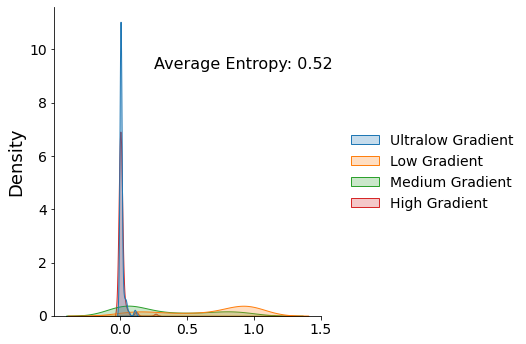

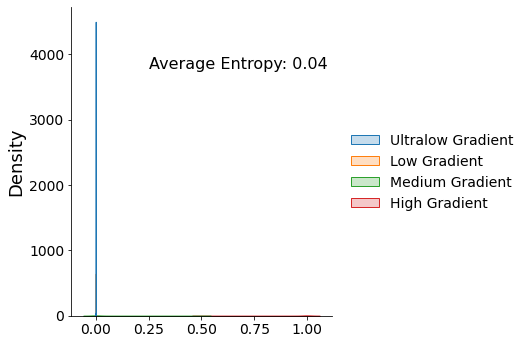

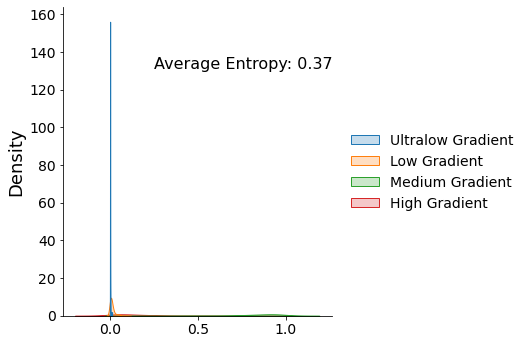

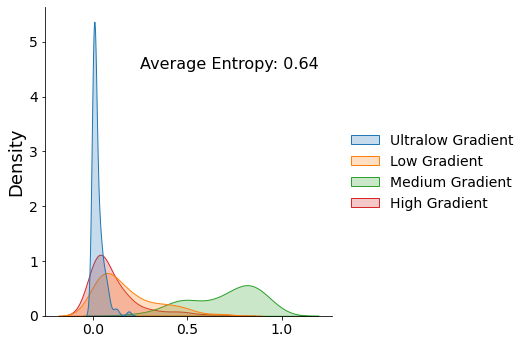

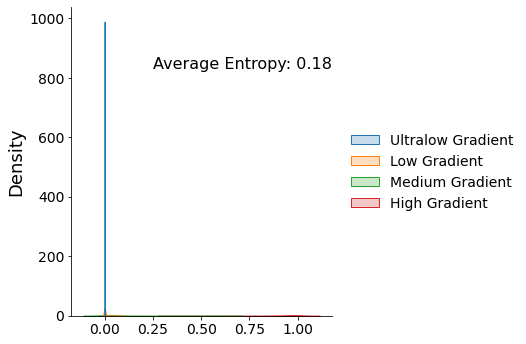

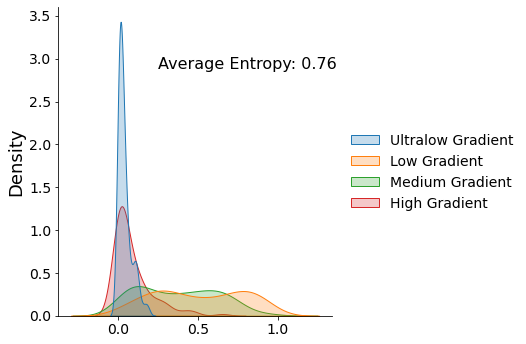

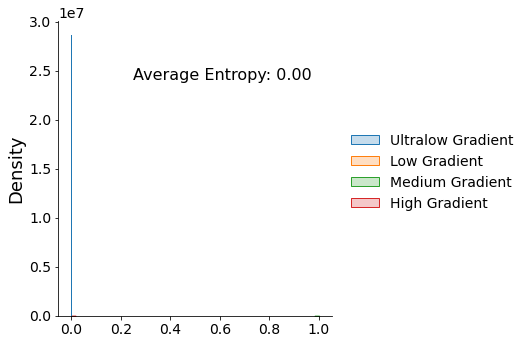

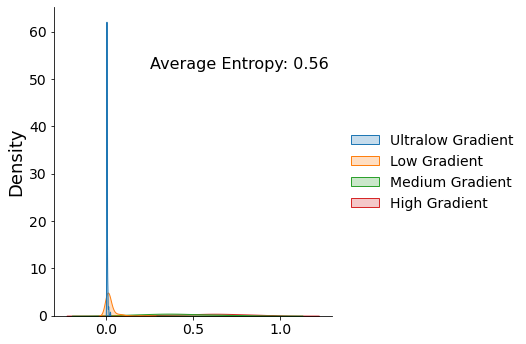

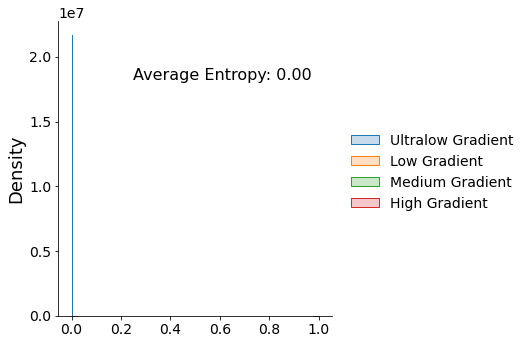

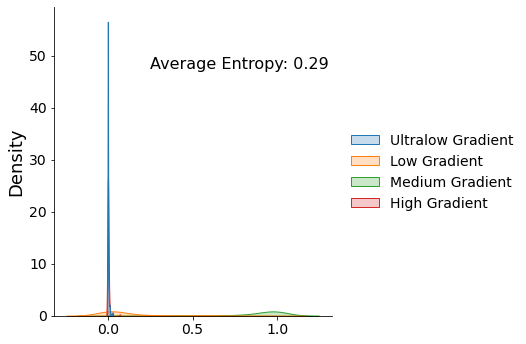

In [ ]:
for i in range(30,40):
  examine_model_predictions(i);

## Load full dataset and predict

In [19]:
with open(datafolder/ "full_shared.pkl","rb") as handle: 
    fulldatadict = pkl.load(handle)
    
# unpack
FULLdf = fulldatadict['data']
FULLcoords = fulldatadict['coords']

pfa_result = FULLdf['GeothermGrad_4class']

# drop unnecessary columns
FULLdf = FULLdf[incols]

# scale and transform the data to match the training data
FULLdfsc = pd.DataFrame(pl.transform(FULLdf), columns=colnames)

# use all data
Xallsc = pd.concat([Xtrsc[colnames],Xvlsc[colnames],Xtssc[colnames]])
yc_oh_all=np.vstack((yc_oh_train,yc_oh_val,yc_oh_test))

## Calculate results over 1000 passes through BNN trained on ALL data

In [ ]:
# Retrain on ALL data 
pmodel_all = tfk.Sequential([
      tfk.layers.Dense(len(incols), 
                       activation="relu", 
                       input_shape=(len(incols),), 
                       kernel_initializer='he_normal',
                       name="HiddenLayer1"), # Hidden layer 1
      tfk.layers.Dropout(0.0, name="Dropout1"),
      tfpl.DenseVariational(units=len(incols), 
                            make_prior_fn=prior, 
                            make_posterior_fn=posterior,  # Probabilistic hidden layer
                            kl_weight=1/Xtrsc.shape[0], 
                            kl_use_exact=True, 
                            name="HiddenLayer2"),
      tfk.layers.Dropout(0.0, name="Dropout2"),
      tfk.layers.Dense(len(code2label), 
                       activation='softmax', 
                       name="OutputLayer") # Output layer
    ], name="BNN_Model")

# Compile model
pmodel_all.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=tfk.metrics.AUC(curve='ROC', multi_label=False))

# Run training session.
results = pmodel_all.fit(x=Xallsc,
                        y=yc_oh_all,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        validation_data=(Xvlsc,yc_oh_val),
                        verbose=True)

# Describe model.
pmodel_all.summary()

Epoch 1/200
67/67 [==============================] - 3s 23ms/step - loss: 5.1550 - auc_3: 0.5391 - val_loss: 5.2760 - val_auc_3: 0.4936
Epoch 2/200
67/67 [==============================] - 1s 16ms/step - loss: 5.0709 - auc_3: 0.5271 - val_loss: 3.6933 - val_auc_3: 0.6422
Epoch 3/200
67/67 [==============================] - 1s 16ms/step - loss: 4.0086 - auc_3: 0.5613 - val_loss: 3.6857 - val_auc_3: 0.6268
Epoch 4/200
67/67 [==============================] - 1s 16ms/step - loss: 2.9781 - auc_3: 0.6311 - val_loss: 2.4617 - val_auc_3: 0.6515
Epoch 5/200
67/67 [==============================] - 1s 16ms/step - loss: 2.5388 - auc_3: 0.6263 - val_loss: 1.7192 - val_auc_3: 0.6893
Epoch 6/200
67/67 [==============================] - 1s 15ms/step - loss: 2.0911 - auc_3: 0.6647 - val_loss: 1.7938 - val_auc_3: 0.6997
Epoch 7/200
67/67 [==============================] - 1s 16ms/step - loss: 2.0265 - auc_3: 0.6633 - val_loss: 1.7179 - val_auc_3: 0.6954
Epoch 8/200
67/67 [=============================

### Run model on the Full Data Set 1000x

In [ ]:
n = 1000
nc = len(code2label)
FULL_pp = np.empty(shape=(n,FULLdfsc.shape[0],nc))
for i in range(n):
  if(i%100 == 0): print('BNN run ',i)
  FULL_pp[i] = pmodel_all.predict(FULLdfsc)

BNN run  0
BNN run  100
BNN run  200
BNN run  300
BNN run  400
BNN run  500
BNN run  600
BNN run  700
BNN run  800
BNN run  900


#### Calculate Distribution Summation (i.e. sum) for each class label for each map location

In [ ]:
#FULL_pp
sum_FULL_pp = np.sum(FULL_pp,axis=0)
sum_FULL_pp

array([[1.19837817e-09, 1.60449181e-05, 9.38683266e+02, 6.13167176e+01],
       [7.10409432e-09, 3.23095183e-04, 9.96009662e+02, 3.99001535e+00],
       [8.24006796e-08, 1.05199338e-03, 9.66787034e+02, 3.32119139e+01],
       ...,
       [4.83557701e+02, 1.87582954e+02, 7.64286970e+01, 2.52430647e+02],
       [5.92974292e+02, 2.36474165e+02, 3.23466466e+01, 1.38204897e+02],
       [6.46456607e+02, 3.24305749e+02, 9.32376280e+00, 1.99138811e+01]])

Save out for use in other scripts

In [ ]:
# save out for use in other scripts
shared = {
          "coords":FULLcoords,
          "full_dataset":FULLdf,
          "full_dataset_scaled":FULLdfsc,
          "selected_columns":FULLdf.columns,
          "FULL_pp":FULL_pp,
          "sum_FULL_pp":sum_FULL_pp
         }
with open(datafolder / "parameter_uncertainty_results.pkl","wb") as handle:
  pkl.dump(shared, handle, protocol=pkl.HIGHEST_PROTOCOL)

pmodel_all.save_weights(datafolder / 'bnn_WDS4_weights.sav')
#pmodel_all.save(datafolder / 'bnn_WDS4_fullmodel.h5')  # doesn't work for BNN

In [ ]:
#with open(datafolder / 'Models' / 'parameter_uncertainty_results.pkl', 'rb') as f:
#    test = pkl.load(f)
#sum_FULL_pp = test['sum_FULL_pp']

#### Plot argmax of the Distribution Summation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


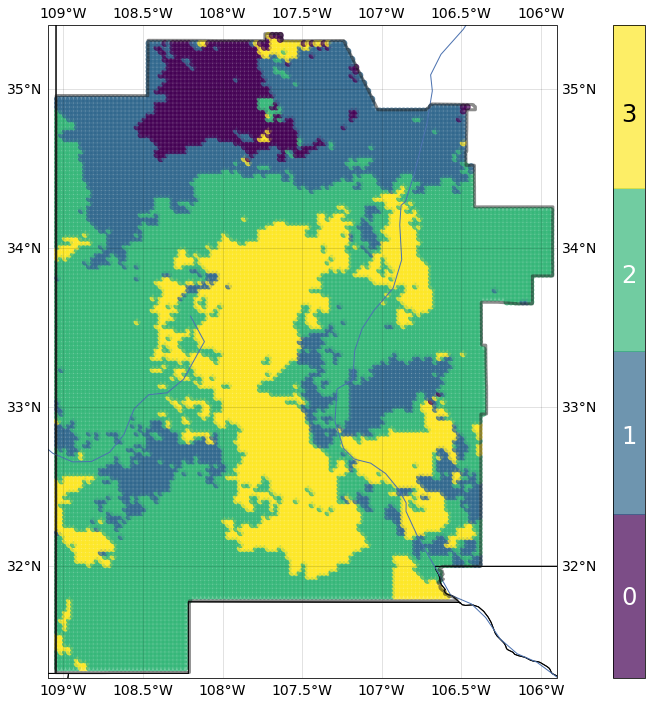

In [ ]:
colmap=plt.cm.get_cmap('viridis', 4)
ax = createBasemap();
pc = ax.scatter(FULLcoords.Longitude,
                FULLcoords.Latitude,
                cmap=colmap,
                c=np.argmax(sum_FULL_pp,axis=1),
                alpha=0.7,
                transform=myprojection);
cbar = plt.colorbar(pc);
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
  if(j==3):
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
              fontsize='xx-large',fontweight='extra bold')
  else:
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                fontsize='xx-large',fontweight='extra bold')

plt.savefig(datafolder / 'Fig-DistributionSummation-ParameterizationUncertainty.png', bbox_inches='tight')

### Calculate and Plot Entropy (interpretated as uncertainty in classification)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


<Figure size 432x288 with 0 Axes>

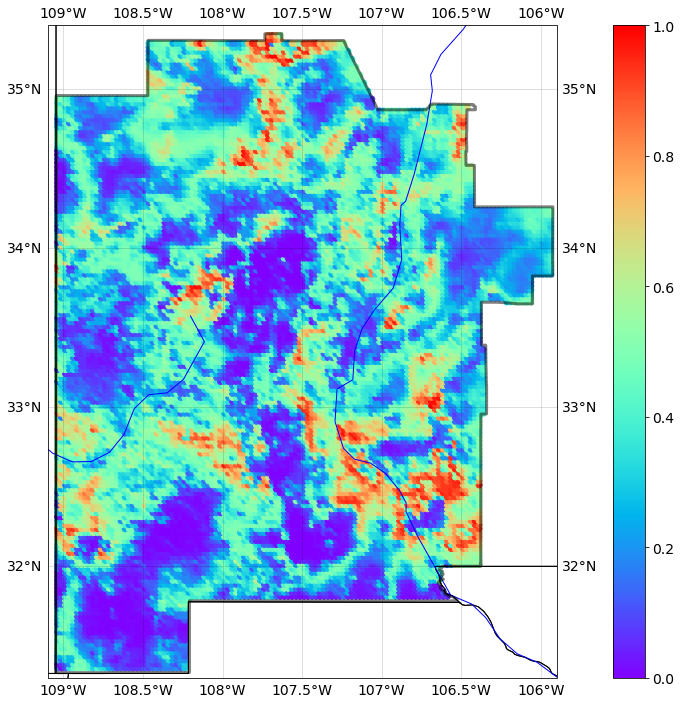

In [25]:
from scipy import stats
import math

# entropy from distribution summation
ent_FULL_pp = stats.entropy(sum_FULL_pp,base=len(code2label),axis=-1)
ent_FULL_pp.shape

plt.figure()
ax = createBasemap();
pc = ax.scatter(FULLcoords.Longitude,
                FULLcoords.Latitude,
                cmap='rainbow',
                c=ent_FULL_pp,
                alpha=1.,
                vmin=0.0,
                vmax=1.0,
                transform=myprojection);

plt.colorbar(pc);
plt.savefig(datafolder/'Fig-Entropy_ParameterizationUncertainty.png', bbox_inches='tight')

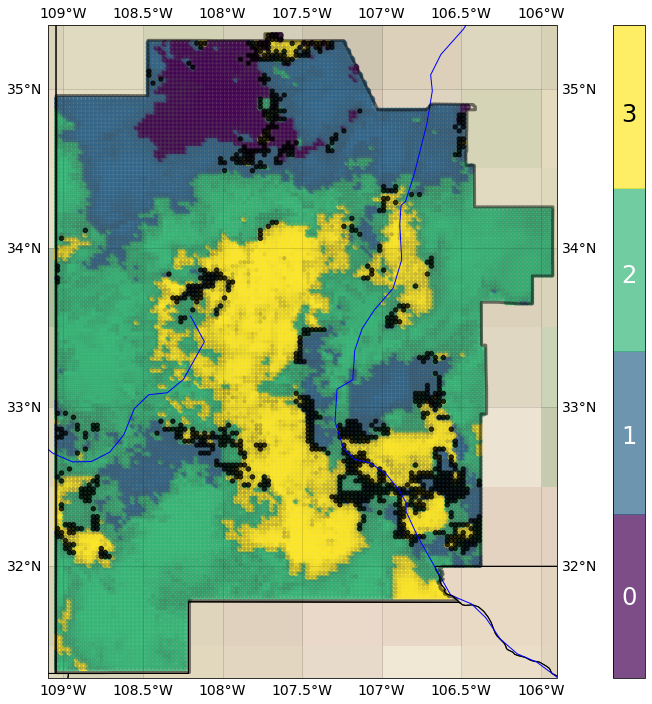

In [27]:
mask = True
# create base image for map
expl_area = datafolder / 'Exploration_area.shp'
expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')

plt.figure(figsize=(20,12))
ax = plt.axes(projection=myprojection)
ax.stock_img()
    
ax.add_feature(cartopy.feature.STATES)
ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
ax.add_feature(expl_area_feat, facecolor='None', edgecolor='k', linewidth=3, alpha = 0.5)
ax.set_extent(extent,crs=myprojection)

gl = ax.gridlines(crs = myprojection, draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.25, linestyle='-')
colmap=plt.cm.get_cmap('viridis', 4)

rgba_colors = np.zeros((len(ent_FULL_pp),4))
rgba_colors[:,0] = rgba_colors[:,1] = rgba_colors[:,2] = 0.0

pc = ax.scatter(FULLcoords.Longitude,
                FULLcoords.Latitude,
                cmap=colmap,
                c=np.argmax(sum_FULL_pp,axis=1),
                alpha=.7, #s= 20,
                transform=myprojection);
cbar = plt.colorbar(pc)
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
  if(j==3):
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
              fontsize='xx-large',fontweight='extra bold')
  else:
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                fontsize='xx-large',fontweight='extra bold')
if mask == True:
  # add alpha values
  rgba_colors[:, 3] = [0 if x<0.7 else .8 for x in ent_FULL_pp]
  pc = ax.scatter(FULLcoords.Longitude,
                  FULLcoords.Latitude,
                  s = 20,
                  color=rgba_colors,
                  transform=myprojection);

  rgba_colors[:,0] = rgba_colors[:,1] = rgba_colors[:,2] = 0.25
  rgba_colors[:, 3] = [0 if x>0.7 else x/2 for x in ent_FULL_pp]
  pc = ax.scatter(FULLcoords.Longitude,
                  FULLcoords.Latitude,
                  s = 10,
                  color=rgba_colors,
                  transform=myprojection);

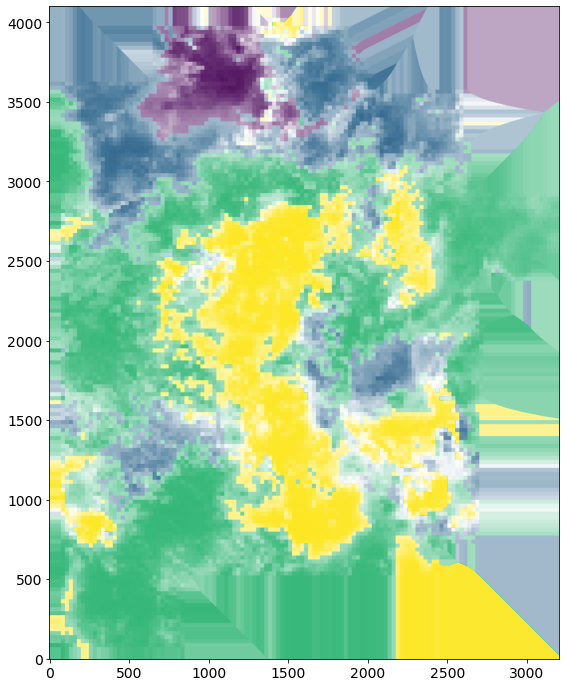

In [28]:
from scipy.interpolate import griddata
nmap=3
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
numx = int(((xmax-xmin)/.001) +1)
numy = int(((ymax-ymin)/.001) +1)

xi = np.linspace(xmin,xmax,numx)
yi = np.linspace(ymin,ymax,numy)
zi = griddata((FULLcoords.Longitude,FULLcoords.Latitude),np.argmax(sum_FULL_pp,axis=1), (xi[None,:], yi[:,None]),method='nearest')
ai = griddata((FULLcoords.Longitude,FULLcoords.Latitude),1-ent_FULL_pp, (xi[None,:], yi[:,None]),method='nearest')

plt.figure(figsize=(20,12))
plt.imshow(zi,cmap='viridis',vmin=0,vmax=3,alpha=ai)
plt.gca().invert_yaxis()

In [29]:
from scipy.interpolate import griddata
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
numx = int(((xmax-xmin)/.025) +1)
numy = int(((ymax-ymin)/.025) +1)
xi = np.linspace(xmin,xmax,numx)
yi = np.linspace(ymin,ymax,numy)
grid_x, grid_y = np.meshgrid(xi,yi)
zi = griddata((FULLcoords.Longitude,FULLcoords.Latitude),np.argmax(sum_FULL_pp,axis=1), (xi[None,:], yi[:,None]),method='nearest')
ai = griddata((FULLcoords.Longitude,FULLcoords.Latitude),1-ent_FULL_pp, (xi[None,:], yi[:,None]),method='nearest')

In [30]:
gdf = gpd.GeoDataFrame({"Longitude":grid_x.reshape(-1,1).squeeze(), 
                        "Latitude":grid_y.reshape(-1,1).squeeze(), 
                        "GeothermalClass":zi.reshape(-1,1).squeeze(), 
                        "Unentropy":ai.reshape(-1,1).squeeze()},
                       crs = {'init': 'epsg:4326'})
gdf['geometry']=gpd.points_from_xy(gdf.Longitude,gdf.Latitude)
for p in expl_area_feat.geometries():
  break;
  
gdf=gpd.clip(gdf,p)

In [32]:
#import matplotlib as mpl 
mpl.__version__

norm = mpl.colors.Normalize(vmin=0.0, vmax=3.0)
cmap = mpl.cm.get_cmap('viridis',4)

colors = [cmap(norm(c), alpha=a**1.5) for c,a in zip(gdf.GeothermalClass.to_list(),gdf.Unentropy.to_list())]
colors = [cmap(c, alpha=a**1.5) for c,a in zip(gdf.GeothermalClass.to_list(),gdf.Unentropy.to_list())]
print(colors)

[(0.190631, 0.407061, 0.556089, 0.24986688584025094), (0.190631, 0.407061, 0.556089, 0.21790584020836914), (0.190631, 0.407061, 0.556089, 0.45829411242155477), (0.190631, 0.407061, 0.556089, 0.3564772008906382), (0.190631, 0.407061, 0.556089, 0.5030728492136526), (0.190631, 0.407061, 0.556089, 0.38228223971028297), (0.190631, 0.407061, 0.556089, 0.410162758165507), (0.190631, 0.407061, 0.556089, 0.4748104134556004), (0.190631, 0.407061, 0.556089, 0.3778720006545239), (0.190631, 0.407061, 0.556089, 0.4474009426558921), (0.190631, 0.407061, 0.556089, 0.36231621180922907), (0.190631, 0.407061, 0.556089, 0.36484441053478145), (0.190631, 0.407061, 0.556089, 0.37337985494368864), (0.190631, 0.407061, 0.556089, 0.4080905019117816), (0.190631, 0.407061, 0.556089, 0.41389263814220445), (0.190631, 0.407061, 0.556089, 0.4671332880852108), (0.190631, 0.407061, 0.556089, 0.16767899512987536), (0.190631, 0.407061, 0.556089, 0.5109964145071648), (0.190631, 0.407061, 0.556089, 0.33501253815968207), (0

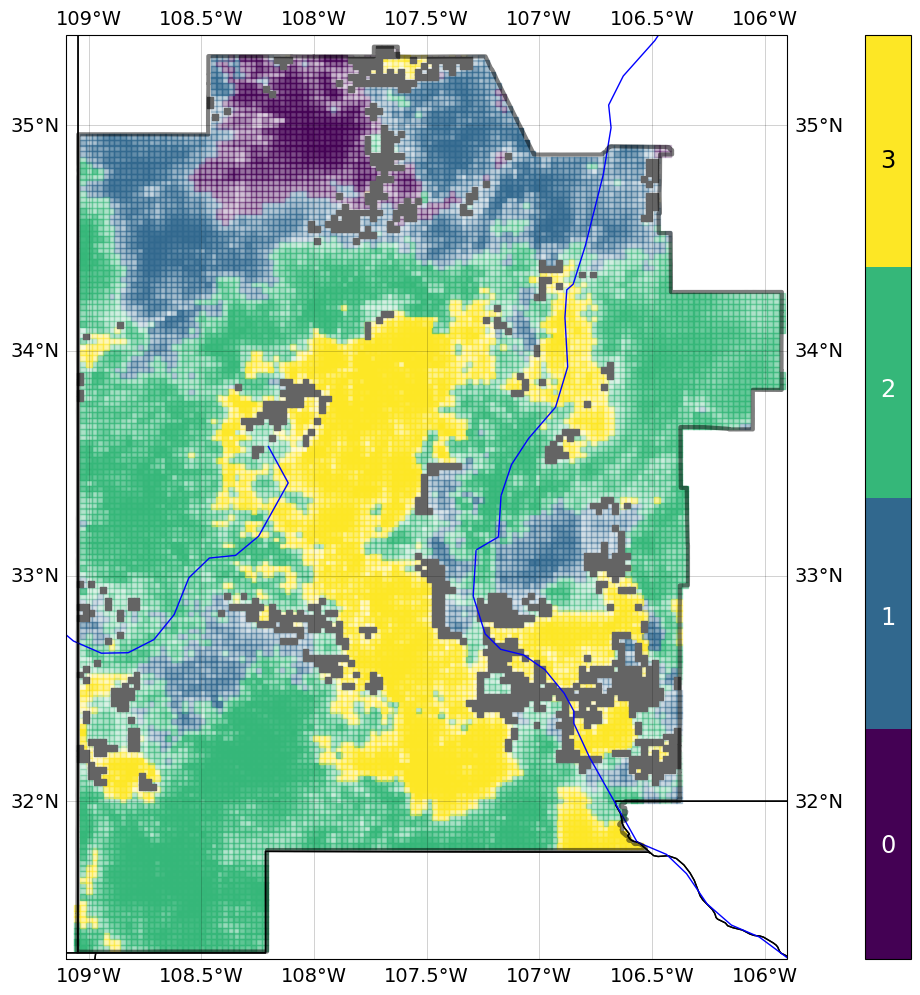

In [33]:
mask = True
# create base image for map
expl_area = datafolder / 'Exploration_area.shp'
expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')

with mpl.style.context('default'):
  plt.figure(figsize=(20,12))
  ax = plt.axes(projection=myprojection)
  #ax.stock_img()
      
  ax.add_feature(cartopy.feature.STATES)
  ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
  ax.add_feature(expl_area_feat, facecolor='None', edgecolor='k', linewidth=3, alpha = 0.5)
  ax.set_extent(extent,crs=myprojection)

  # plot lat/lon grid 
  gl = ax.gridlines(crs = myprojection, draw_labels=True,
                    linewidth=0.5, color='k', alpha=0.25, linestyle='-')
  
  # plot zero-sized symbols to establish colorbar
  pc = ax.scatter(gdf.Longitude,
                  gdf.Latitude,
                  cmap = cmap,
                  alpha=1,
                  c=gdf.GeothermalClass,
                  s=0,
                  transform=myprojection)
  cbar = plt.colorbar(pc)
  cbar.ax.get_yaxis().set_ticks([])
  for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
    if(j==3):
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
                fontsize='xx-large',fontweight='extra bold')
    else:
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                  fontsize='xx-large',fontweight='extra bold')
      
  # plot actual symbols with transparency
  pc = ax.scatter(gdf.Longitude,
                  gdf.Latitude,
                  c=colors,
                  marker='s',
                  s=18,
                  transform=myprojection)
  if mask == True:

    # add black-out
    #masked_colors = [c if c[-1]>(0.3**2) else (64,64,64,1) for c in rgba_colors ]
    
    rgba_colors = np.zeros((len(ent_FULL_pp),4))
    rgba_colors[:,0] = [0 if x<0.7 else 100/256 for x in ent_FULL_pp]
    rgba_colors[:,1] = [0 if x<0.7 else 100/256 for x in ent_FULL_pp]
    rgba_colors[:,2] = [0 if x<0.7 else 100/256 for x in ent_FULL_pp]
    rgba_colors[:, 3] = [0 if x<0.7 else 1 for x in ent_FULL_pp]
    pc = ax.scatter(FULLcoords.Longitude,
                    FULLcoords.Latitude,
                    marker='s',
                    s = 18,
                    color=rgba_colors,
                    transform=myprojection);

plt.savefig(datafolder / 'Fig-Masked_ParameterizationUncertainty.png', bbox_inches='tight')